<a href="https://colab.research.google.com/github/djordjeviiccmilos/Data_Analisys/blob/main/MilosDjordjevic137RN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Statisticka analiza saobracajnih nesreca u New York City**

# **Uvod**

---


U skupu podataka koji je koriscen za izradu ovog projekta nalaze se sinteticki podaci o saobracajnim nezgodama

Dataset sadrzi podatke kao sto su:


*   Collision ID - ID nesrece
*   Date - Datum nesrece
*   Time - Vreme nesrece
*   Borough - Naselje u kome se desila  
      nesreca
*   Street name - Ulica u kome se desila
      nesreca
*   Cross Street - Najbliza raskrsnica do nesrece
*   Latitude - Geografska sirina
*   Longitude - Geografska duzina
*   Contributing Factor - Faktori koji su uticali na to da se nesreca desi
*   Vehicle Type - Tip vozila
*   Persons Injured - Ukupan broj povredjenih ljudi u nesreci
*   Persons Killed - Ukupan broj poginulih ljudi u nesreci
*   Pedestrians Injured - Broj povredjenih pesaka
*   Pedestrians Killed - Broj poginulih pesaka
*   Cyclists Injured - Broj povredjenih biciklista
*   Cyclists Killed - Broj poginulih biciklista
*   Motorists Injured - Broj povredjenih vozaca
*   Motorists Killed - Broj poginulih vozaca

---

**Ciljevi analize**

---

1.   *Opisna statistika i osnovne analize*

    *   Osnovne statistike o saobracajnim nesrecama (prosecan broj povreda, smrtnost, ucestalost nesreca)
    *   Vizualni prikaz raspodela po vremenu (po danima, satima, mesecima, godisnjim dobima)
    *   Prostorna raspodela nesreca po naseljima

---

2.   *Analiza vremenskih obrazaca nesreca*

    *   Da li ima vise nesreca leti ili zimi?
    *   U kojim satima dana se desava najvise nesreca?
    *   Da li se vikendom desava vise nesreca nego radnim danima?

---

3.    *Analiza uzroka nesreca*

    *   Koji faktori najcesce dovode do nesreca?
    *   Da li odredjeni faktori znacajno povecavaju broj povreda i smrtnih slucajeva?
    *   Analiza korelacije izmedju uzroka i ozbiljnosti nesrece

---

4.  *Analiza tipova vozila ukljucenih u nesrece*

    *   Koji tipovi vozila su najcesce ukljuceni u nesrece?
    *   Da li odredjeni tip vozila ima vece stope smrtnosti?

---

5.  *Analiza povreda i smrtnih ishoda*

    *   Kolika je verovatnoca da nesreca bude fatalna?
    *   Da li postoji razlika u smrtnosti izmedju razlicitih naselja u gradu?
    *   Analiza odnosa izmedju broja ucesnika u nesreci i tezine povreda
    *   Gde su najopasnija mesta u gradu?

---

6.  *Testiranje statistickih hipoteza*

  *   Da li postoji znacajna razlika u broju nesreca izmedju razlicitih naselja?
  *   Da li vikendom ima vise saobracajnih nesreca nego radnim danima?
  *   Da li odredjene ulice imaju znacajno vecu stopu nesreca u odnosu na druge?
  *   Da li alkohol kao faktor dovodi do veceg broja smrtnih ishoda?
  
---


# **1. Opisna statistika i osnovne analize**

---

# **Učitavanje skupa podataka i sredjivanje**

Pre same analize, moramo prvo ucitati podatke i srediti ih da bi sto optimalnije analizirali te podatke.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stat
import matplotlib.image as mpimg

dataset = pd.read_csv("/content/drive/MyDrive/Statistika/NYC_Collisions.csv")

dataset.head(5)

,Collision ID,Date,Time,Borough,Street Name,Cross Street,Latitude,Longitude,Contributing Factor,Vehicle Type,Persons Injured,Persons Killed,Pedestrians Injured,Pedestrians Killed,Cyclists Injured,Cyclists Killed,Motorists Injured,Motorists Killed
0,4491746,2021-01-01,20:00:00,Bronx,Bruckner Expressway,NaN,40.83398,-73.826350,Pavement Slippery,Passenger Vehicle,0.0,0,0,0,0,0,0,0
1,4441905,2021-01-01,05:28:00,Brooklyn,Lafayette Avenue,NaN,40.68730,-73.973656,Unspecified,Passenger Vehicle,0.0,0,0,0,0,0,0,0
2,4382769,2021-01-01,06:00:00,Staten Island,West Shore Expressway,NaN,NaN,NaN,Fell Asleep,Passenger Vehicle,0.0,0,0,0,0,0,0,0
3,4380949,2021-01-01,19:30:00,Bronx,Sedgwick Avenue,Vancortlandt Avenue West,40.88270,-73.892730,NaN,Not Reported,0.0,0,0,0,0,0,0,0
4,4380940,2021-01-01,07:40:00,Brooklyn,Cortelyou Road,Mc Donald Avenue,40.63791,-73.978640,Unspecified,Passenger Vehicle,0.0,0,0,0,0,0,0,0


In [ ]:
dataset.dtypes

,0
Collision ID,int64
Date,object
Time,object
Borough,object
Street Name,object
Cross Street,object
Latitude,float64
Longitude,float64
Contributing Factor,object
Vehicle Type,object


Najpre cemo obrisati nepotrebne kolone koje necemo koristiti u narednim statistickim analizama

In [ ]:
del dataset["Collision ID"]
del dataset["Latitude"]
del dataset["Longitude"]
del dataset["Cross Street"]

Neke kolone cemo prebaciti u odgovarajuci tip podataka. Naime, broj povredjenih pesaka cemo prebaciti u *int*, jer nema potrebe raditi sa *float-om*. Kolonu **Date** ćemo podeliti u tri različite kolone **Day**, **Month** i **Year**. To isto ćemo uraditi i za kolonu **Time** tako što ćemo odvojiti u tri kolone **Hour**, **Minutes** i **Seconds**.

In [ ]:
dataset["Persons Injured"] = dataset["Persons Injured"].fillna(0).astype(int)
dataset.dtypes

,0
Date,object
Time,object
Borough,object
Street Name,object
Contributing Factor,object
Vehicle Type,object
Persons Injured,int64
Persons Killed,int64
Pedestrians Injured,int64
Pedestrians Killed,int64


In [ ]:
dataset[["Year", "Month", "Day"]] = dataset["Date"].str.split("-", expand = True)
del dataset["Date"]
dataset.tail(5)

,Time,Borough,Street Name,Contributing Factor,Vehicle Type,Persons Injured,Persons Killed,Pedestrians Injured,Pedestrians Killed,Cyclists Injured,Cyclists Killed,Motorists Injured,Motorists Killed,Year,Month,Day
238416,04:21:00,Brooklyn,Meeker Avenue,Failure to Yield Right-of-Way,Not Reported,1,0,1,0,0,0,0,0,2023,04,09
238417,08:30:00,Queens,Elbertson Street,Backing Unsafely,Passenger Vehicle,1,0,1,0,0,0,0,0,2023,04,09
238418,21:19:00,Brooklyn,Cortelyou Road,Unspecified,Passenger Vehicle,1,0,1,0,0,0,0,0,2023,04,09
238419,11:00:00,Manhattan,West 50 Street,Driver Inattention/Distraction,Transport,0,0,0,0,0,0,0,0,2023,04,09
238420,19:10:00,Bronx,Watson Avenue,Driver Inattention/Distraction,Passenger Vehicle,0,0,0,0,0,0,0,0,2023,04,09


In [ ]:
dataset[["Hour", "Minutes", "Seconds"]] = dataset["Time"].str.split(":", expand = True)
del dataset["Time"]
dataset.tail(5)

,Borough,Street Name,Contributing Factor,Vehicle Type,Persons Injured,Persons Killed,Pedestrians Injured,Pedestrians Killed,Cyclists Injured,Cyclists Killed,Motorists Injured,Motorists Killed,Year,Month,Day,Hour,Minutes,Seconds
238416,Brooklyn,Meeker Avenue,Failure to Yield Right-of-Way,Not Reported,1,0,1,0,0,0,0,0,2023,04,09,04,21,00
238417,Queens,Elbertson Street,Backing Unsafely,Passenger Vehicle,1,0,1,0,0,0,0,0,2023,04,09,08,30,00
238418,Brooklyn,Cortelyou Road,Unspecified,Passenger Vehicle,1,0,1,0,0,0,0,0,2023,04,09,21,19,00
238419,Manhattan,West 50 Street,Driver Inattention/Distraction,Transport,0,0,0,0,0,0,0,0,2023,04,09,11,00,00
238420,Bronx,Watson Avenue,Driver Inattention/Distraction,Passenger Vehicle,0,0,0,0,0,0,0,0,2023,04,09,19,10,00


Nakon sredjivanja skupa podataka, možemo preći na opisne statistike i osnovne analize.

# **Analiza podataka**


1.   **Osnovne statistike o saobracajnim nesrecama (prosecan broj povreda, smrtnost, ucestalost nesreca po naseljima)**


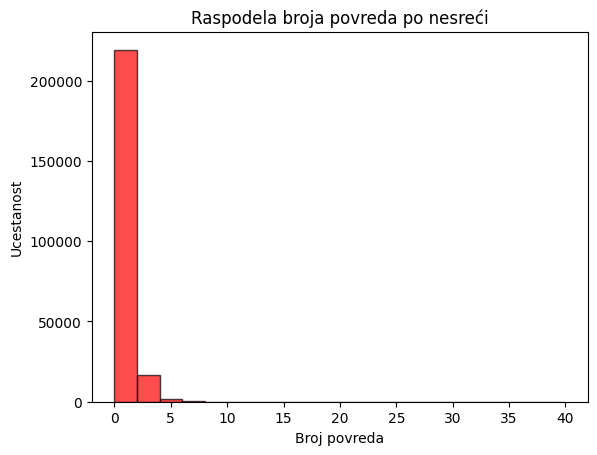

In [ ]:
plt.hist(dataset["Persons Injured"], bins=20, color="red", edgecolor="black", alpha=0.7)

plt.title("Raspodela broja povreda po nesreći")
plt.xlabel("Broj povreda")
plt.ylabel("Ucestanost")

plt.show()

Iz histograma vidimo da vidimo da je raspodela broja povreda slična kao geometrijska raspodela. Dodaćemo funkciju na ovaj grafik da ih uporedimo.

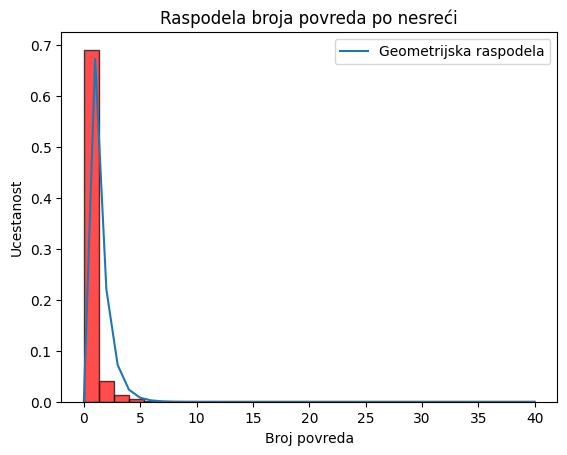

In [ ]:
plt.hist(dataset["Persons Injured"], bins=30, density = True, color="red", edgecolor="black", alpha=0.7)

mean_val = dataset["Persons Injured"].mean()
p = 1 / (mean_val + 1)
x = np.arange(0, max(dataset["Persons Injured"]) + 1)
y = stat.geom.pmf(x, p)

plt.plot(x, y, label="Geometrijska raspodela")


plt.title("Raspodela broja povreda po nesreći")
plt.xlabel("Broj povreda")
plt.ylabel("Ucestanost")
plt.legend()

plt.show()

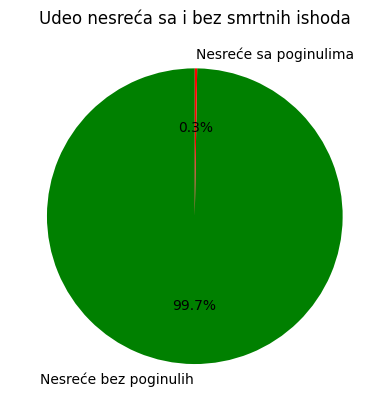

In [ ]:
fatal_accidents = dataset[dataset["Persons Killed"] > 0].shape[0]
non_fatal_accidents = dataset[dataset["Persons Killed"] == 0].shape[0]

sizes = [non_fatal_accidents, fatal_accidents]
labels = ["Nesreće bez poginulih", "Nesreće sa poginulima"]

plt.pie(sizes, labels = labels, autopct="%1.1f%%", colors = ["green", "red"], startangle = 90)

plt.title("Udeo nesreća sa i bez smrtnih ishoda")

plt.show()

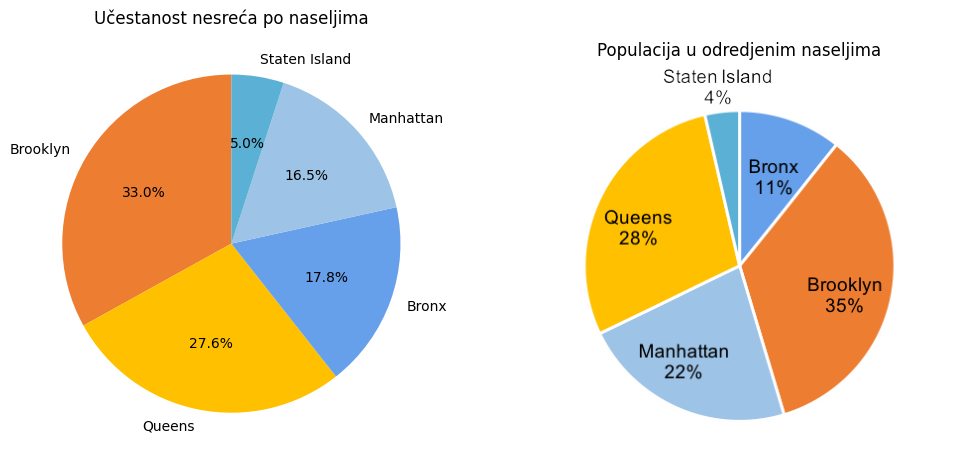

In [ ]:
borough_counts = dataset["Borough"].value_counts()

img = mpimg.imread("/content/drive/MyDrive/Statistika/naselja.png")

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

colors = ["#ed7d31", "#ffc000", "#669fea", "#9dc3e6", "#5bb1d5"]

ax[0].pie(borough_counts, labels = borough_counts.index, colors = colors, autopct='%1.1f%%', startangle = 90)
ax[0].set_title("Učestanost nesreća po naseljima")

ax[1].imshow(img)
ax[1].set_title("Populacija u odredjenim naseljima")
ax[1].axis("off")

plt.show()

2. **Vizualni prikaz raspodela po vremenu (po danima, satima, mesecima, godišnjim dobima)**